In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import networkx as nx
import time
import math
import sys
from sklearn.decomposition import PCA
import scipy.sparse.linalg as ll
import sklearn.preprocessing as skpp

In [3]:
def construct_A(x, eps):
    """
    construct Adjacency matrix A using Euclidean distance
    """
    A = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            temp_dist= math.sqrt(sum(np.power((x[i]-x[j]),2)))
            if temp_dist < eps:
                A[i][j] = temp_dist
            else:
                A[i][j] = float("inf")
    return A            

In [121]:
def construct_A_Manhattan(x, eps):
    """
    construct Adjacency matrix A using Manhattan distance
    """
    A = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            temp_dist= sum(abs(x[i,:] - x[j,:] ))
            if temp_dist < eps:
                A[i][j] = temp_dist
            else:
                A[i][j] = float("inf")
    return A     

In [7]:
def isSymmetric(mat, N): 
    for i in range(N): 
        for j in range(N): 
            if (mat[i][j] != mat[j][i]): 
                return False
    return True

In [6]:
def Matrix_D(W):
    # Generate Graph and Obtain Matrix D, \\
    # from weight matrix W defining the weight on the edge between each pair of nodes.
    # Note that you can assign sufficiently large weights to non-existing edges.

    n = np.shape(W)[0]
    Graph = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            Graph.add_weighted_edges_from([(i,j,min(W[i,j], W[j,i]))])

    res = dict(nx.all_pairs_dijkstra_path_length(Graph))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = res[i][j]
    np.savetxt('D.csv', D)
    return D

In [135]:
def perform_PCA(x, k):
    
    """
    inputs: x matrix , k: number of principal components
    output: matrix of projected x
    """
    #calculate covariance matrix
    m,n = x.shape
    mu = np.mean(x,axis = 1)
    xc = x - mu[:,None]

    C = np.dot(xc,xc.T)/m

    eigenval, eigenvec = np.linalg.eig(C)
    #find the index of sorted eigenvalues from largest to smallest
    index = np.argsort(eigenval)[::-1]   
   
    sorted_val = eigenval.real[index]
    sorted_vec = eigenvec.real[:, index]

    Z= np.zeros((x.shape[1],k))
    for i in range(k):  
        z = np.dot(sorted_vec[:,i].T,xc)/math.sqrt(sorted_val[i]) # extract 1st eigenvalues
        Z[:,i]=z
        
    new_X = np.dot(x, Z)
    return new_X

In [9]:
# load images
images = loadmat('isomap.mat')['images']

#the images should be transposed because based on paper 4096 corresponds to brightness of each picture(64*64) 
# 698 is the number of pictures
images_transpose = images.transpose()

num_images, num_pixels = images_transpose.shape
pixels_per_dimension = int(math.sqrt(num_pixels))

In [13]:
#find epsilon for Euclidean distance
max_neighbors =100
i=0
eps=0.1
x = images_transpose
while i < len(x):
    count=0
    for j in range(len(x)):
        temp_dist= math.sqrt(sum(np.power((x[i]-x[j]),2)))
        if temp_dist < eps:
            count = count+1
    if count < max_neighbors:
        eps = eps*1.5
        continue 
    else:
        i=i+1
eps

29.192926025390626

In [146]:
#find epsilon for Manhattan distance
max_neighbors =10
i=0
eps_M=0.1
while i < len(x):
    count=0
    for j in range(len(x)):
        temp_dist= sum(abs(x[i,:] - x[j,:] ))
        if temp_dist < eps_M:
            count = count+1
    if count < max_neighbors:
        eps_M = eps_M+2
        continue 
    else:
        i=i+1
eps_M

588.1

In [103]:
#using Euclidean distance for ISOMAP

eps = 12.97

start = time.time()
A = construct_A(images_transpose, eps)

end = time.time()
print ((end-start)/60  , 'mins , matrix A is constructed')

D = Matrix_D(A)

print ((end-start)/60  , 'mins , matrix D is constructed')

identity = np.identity(images_transpose.shape[0])
one = np.ones(images_transpose.shape[0])
one_T = one.transpose()

H = identity - (1.0/float(images_transpose.shape[0]))* np.outer(one_T,one)

D2 = np.power(D,2)

C = (-1.0/float(2*images_transpose.shape[0]))*np.dot(H,np.dot(D2,H))

eigenval, eigenvec = np.linalg.eig(C)
#find the index of sorted eigenvalues from largest to smallest
index = np.argsort(eigenval)[::-1]   
eigenval = eigenval[index]
eigenvec = eigenvec.real[:, index]

# dimension reduction
K = eigenvec[:, :k]
L = np.diag(np.sqrt(eigenval.real[:k]))


Z = np.dot(K,L)

(6.617683331171672, 'mins , matrix A is constructed')
(6.617683331171672, 'mins , matrix D is constructed')


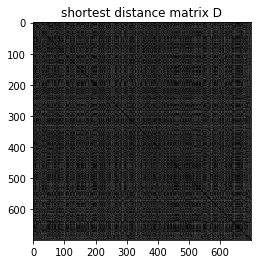

In [117]:
#dissimilarity matrix

plt.imshow(D,cmap='gray', vmin=0, vmax=255)
plt.title('shortest distance matrix D')
plt.show()

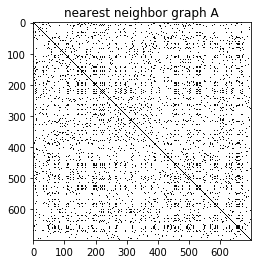

In [115]:
#adjacensy matrix
plt.imshow(A,cmap='gray', vmin=0, vmax=255)
plt.title('nearest neighbor graph A')
plt.show()

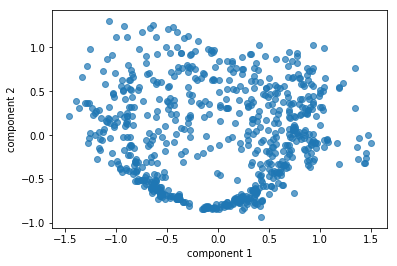

In [542]:
plt.scatter(Z[:,0], Z[:,1],alpha=0.7)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

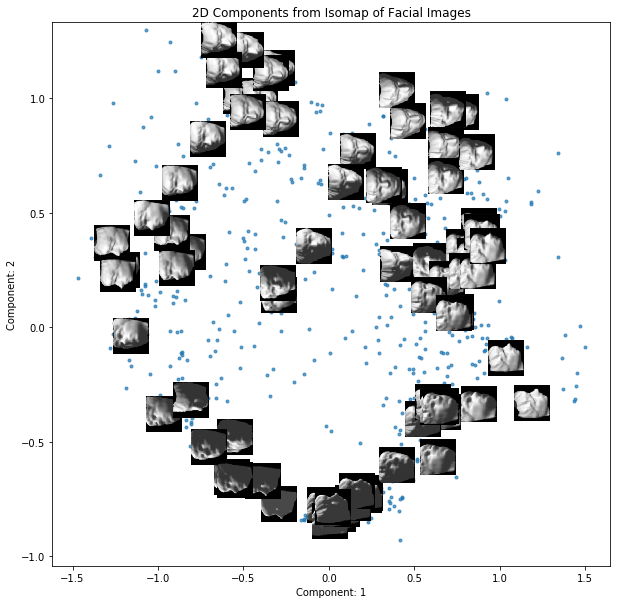

In [543]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.set_title('2D Components from Isomap of Facial Images')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')

x_size = (max(Z[:,0]) - min(Z[:,0])) * 0.07
y_size = (max(Z[:,1]) - min(Z[:,1])) * 0.07
for i in range(80):
    img_num = np.random.randint(0, num_images)
    x0 = Z[img_num][0] - (x_size / 2.)
    y0 = Z[img_num][1] - (y_size / 2.)
    x1 = Z[img_num][0] + (x_size / 2.)
    y1 = Z[img_num][1] + (y_size / 2.)
    img = images_transpose[img_num,:].reshape(pixels_per_dimension, pixels_per_dimension)
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray, 
              interpolation='nearest', zorder=10000, extent=(x0, x1, y0, y1))

# Show 2D components plot
ax.scatter(Z[:,0], Z[:,1], marker='.',alpha=0.7)


plt.show()

In [147]:
#using Manhattan distance for ISOMAP

eps_M = 588.1
k=2
start = time.time()
A = construct_A_Manhattan(images_transpose, eps_M)

end = time.time()
print ((end-start)/60  , 'mins , matrix A is constructed')

D = Matrix_D(A)

print ((end-start)/60  , 'mins , matrix D is constructed')

identity = np.identity(images_transpose.shape[0])
one = np.ones(images_transpose.shape[0])
one_T = one.transpose()

mymatrix = (1.0/float(images_transpose.shape[0]))* np.outer(one_T,one)
H = identity - mymatrix

D2 = np.power(D,2)

C = (-1.0/float(2*images_transpose.shape[0]))*np.dot(H,np.dot(D2,H))

eigenval, eigenvec = np.linalg.eig(C)
#find the index of sorted eigenvalues from largest to smallest
index = np.argsort(eigenval)[::-1]   
eigenval = eigenval[index]
eigenvec = eigenvec.real[:, index]

# dimension reduction
K = eigenvec[:, :k]
L = np.diag(np.sqrt(eigenval.real[:k]))


Z_M = np.dot(K,L)

(5.16886666615804, 'mins , matrix A is constructed')
(5.16886666615804, 'mins , matrix D is constructed')


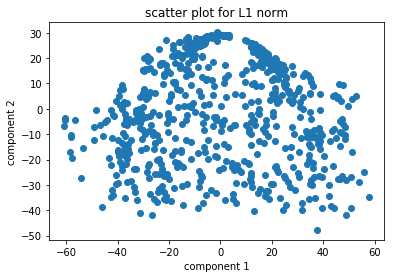

In [148]:
plt.scatter(Z_M[:,0],Z_M[:,1])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('scatter plot for L1 norm')
plt.show()

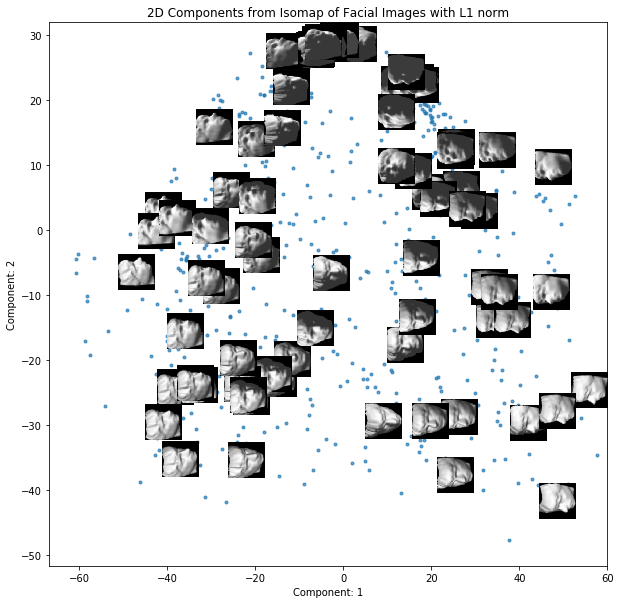

In [149]:

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.set_title('2D Components from Isomap of Facial Images with L1 norm')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')

x_size = (max(Z_M[:,0]) - min(Z_M[:,0])) * 0.07
y_size = (max(Z_M[:,1]) - min(Z_M[:,1])) * 0.07
for i in range(80):
    img_num = np.random.randint(0, num_images)
    x0 = Z_M[img_num][0] - (x_size / 2.)
    y0 = Z_M[img_num][1] - (y_size / 2.)
    x1 = Z_M[img_num][0] + (x_size / 2.)
    y1 = Z_M[img_num][1] + (y_size / 2.)
    img = images_transpose[img_num,:].reshape(pixels_per_dimension, pixels_per_dimension)
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray, 
              interpolation='nearest', zorder=10000, extent=(x0, x1, y0, y1))

# Show 2D components plot
ax.scatter(Z_M[:,0], Z_M[:,1], marker='.',alpha=0.7)


plt.show()

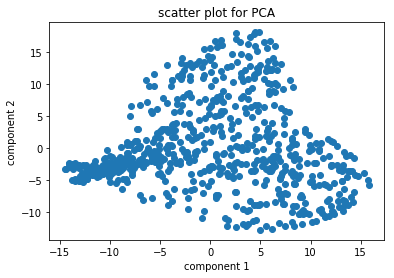

In [136]:
#perform PCA from the function I wrote 
k = 2
X_new = perform_PCA(images_transpose, k)
plt.scatter(x_new[:,0],x_new[:,1])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('scatter plot for PCA')
plt.show()

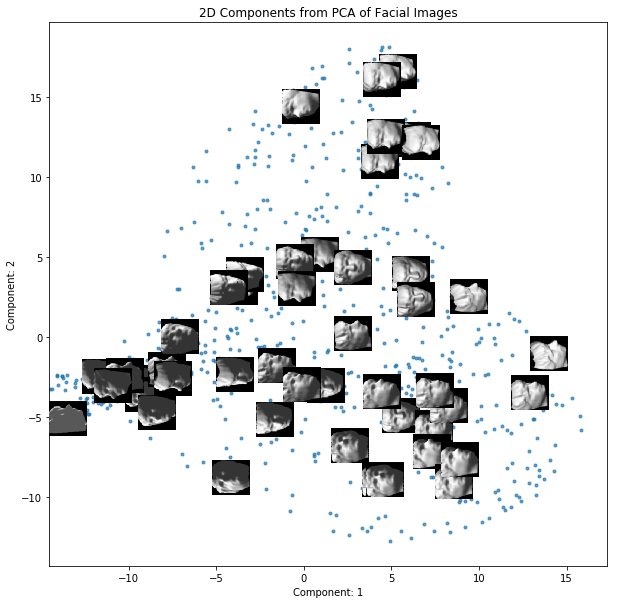

In [456]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.set_title('2D Components from PCA of Facial Images')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')

# Show 40 of the images ont the plot
x_size = (max(x_new[:,0]) - min(x_new[:,0])) * 0.07
y_size = (max(x_new[:,1]) - min(x_new[:,1])) * 0.07
for i in range(50):
    img_num = np.random.randint(0, num_images)
    x0 = x_new[img_num][0] - (x_size / 2.)
    y0 = x_new[img_num][1] - (y_size / 2.)
    x1 = x_new[img_num][0] + (x_size / 2.)
    y1 = x_new[img_num][1] + (y_size / 2.)
    img = images_transpose[img_num,:].reshape(pixels_per_dimension, pixels_per_dimension)
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray, 
              interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

# Show 2D components plot
ax.scatter(x_new[:,0], x_new[:,1], marker='.',alpha=0.7)

plt.show()

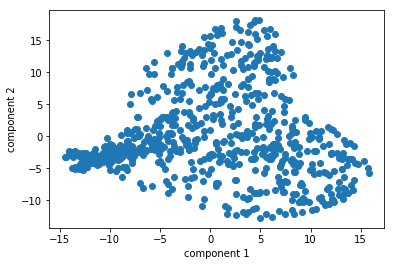

In [119]:
# perform PCA from Sklearn 
pca = PCA(n_components=2)
pca.fit(images_transpose)
x_new = pca.transform(images_transpose)
plt.scatter(x_new[:,0],x_new[:,1])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

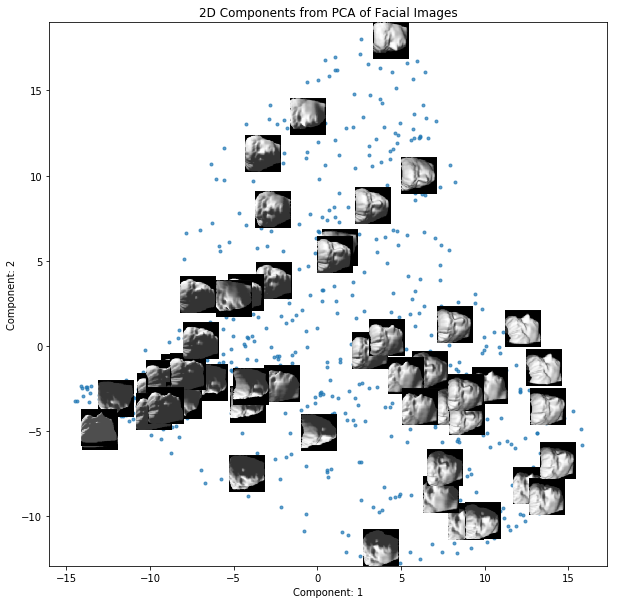

In [451]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.set_title('2D Components from PCA of Facial Images')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')

x_size = (max(x_new[:,0]) - min(x_new[:,0])) * 0.07
y_size = (max(x_new[:,1]) - min(x_new[:,1])) * 0.07
for i in range(50):
    img_num = np.random.randint(0, num_images)
    x0 = x_new[img_num][0] - (x_size / 2.)
    y0 = x_new[img_num][1] - (y_size / 2.)
    x1 = x_new[img_num][0] + (x_size / 2.)
    y1 = x_new[img_num][1] + (y_size / 2.)
    img = images_transpose[img_num,:].reshape(pixels_per_dimension, pixels_per_dimension)
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray, 
              interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

# Show 2D components plot
ax.scatter(x_new[:,0], x_new[:,1], marker='.',alpha=0.7)

plt.show()